In [1]:
# import required libraries for data cleansing
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, image as mpimg
import folium
from scipy import stats
from sklearn import preprocessing, metrics, tree, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score, f1_score, log_loss, classification_report, confusion_matrix
import pydotplus
from six import StringIO


In [2]:

DATAFILE = "https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv"
df = pd.read_csv(DATAFILE)


/tmp/ipykernel_4886/307352804.py:2: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATAFILE)


In [3]:

# convert dates to proper format
df["INCDATE"] = pd.to_datetime(pd.DatetimeIndex(df["INCDATE"]).date)
df["INCDTTM"] = pd.to_datetime(df["INCDTTM"])
df.replace("?", np.nan, inplace=True)


In [4]:

print(df.head())


   SEVERITYCODE           X          Y  OBJECTID  INCKEY  COLDETKEY REPORTNO  \
0             2 -122.323148  47.703140         1    1307       1307  3502005   
1             1 -122.347294  47.647172         2   52200      52200  2607959   
2             1 -122.334540  47.607871         3   26700      26700  1482393   
3             1 -122.334803  47.604803         4    1144       1144  3503937   
4             2 -122.306426  47.545739         5   17700      17700  1807429   

    STATUS      ADDRTYPE   INTKEY  ... ROADCOND                LIGHTCOND  \
0  Matched  Intersection  37475.0  ...      Wet                 Daylight   
1  Matched         Block      NaN  ...      Wet  Dark - Street Lights On   
2  Matched         Block      NaN  ...      Dry                 Daylight   
3  Matched         Block      NaN  ...      Dry                 Daylight   
4  Matched  Intersection  34387.0  ...      Wet                 Daylight   

  PEDROWNOTGRNT  SDOTCOLNUM SPEEDING ST_COLCODE  \
0          

In [5]:

print(df.columns)


Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')


In [6]:

print(df.shape)


(194673, 38)


In [7]:

df.drop(
    [
        "INCKEY",
        "COLDETKEY",
        "REPORTNO",
        "STATUS",
        "INTKEY",
        "EXCEPTRSNCODE",
        "EXCEPTRSNDESC",
        "SEVERITYCODE.1",
        "SEVERITYDESC",
        "SDOT_COLCODE",
        "SDOT_COLDESC",
        "SDOTCOLNUM",
        "ST_COLDESC",
        "SEGLANEKEY",
        "CROSSWALKKEY",
    ],
    axis=1,
    inplace=True,
)


In [8]:

print(df.head())


   SEVERITYCODE           X          Y  OBJECTID      ADDRTYPE  \
0             2 -122.323148  47.703140         1  Intersection   
1             1 -122.347294  47.647172         2         Block   
2             1 -122.334540  47.607871         3         Block   
3             1 -122.334803  47.604803         4         Block   
4             2 -122.306426  47.545739         5  Intersection   

                                      LOCATION COLLISIONTYPE  PERSONCOUNT  \
0                   5TH AVE NE AND NE 103RD ST        Angles            2   
1   AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N     Sideswipe            2   
2  4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST    Parked Car            4   
3     2ND AVE BETWEEN MARION ST AND MADISON ST         Other            3   
4              SWIFT AVE S AND SWIFT AV OFF RP        Angles            2   

   PEDCOUNT  PEDCYLCOUNT  ...                             JUNCTIONTYPE  \
0         0            0  ...   At Intersection (intersection rela

In [9]:

# convert date column to datetime format
df["year"] = pd.DatetimeIndex(df.INCDATE).year
df["month"] = pd.DatetimeIndex(df.INCDATE).month
df["day"] = pd.DatetimeIndex(df.INCDATE).day
df["dayofweek"] = pd.DatetimeIndex(df.INCDATE).dayofweek
df["Hour"] = pd.DatetimeIndex(df.INCDTTM).hour.astype(int)
# group objectID by year for visualization
df_grouped = df[["year", "OBJECTID"]].groupby(by=["year"])
df_counted = df_grouped.count()
df_yr = round(100 * (df_counted / len(df)), 2)


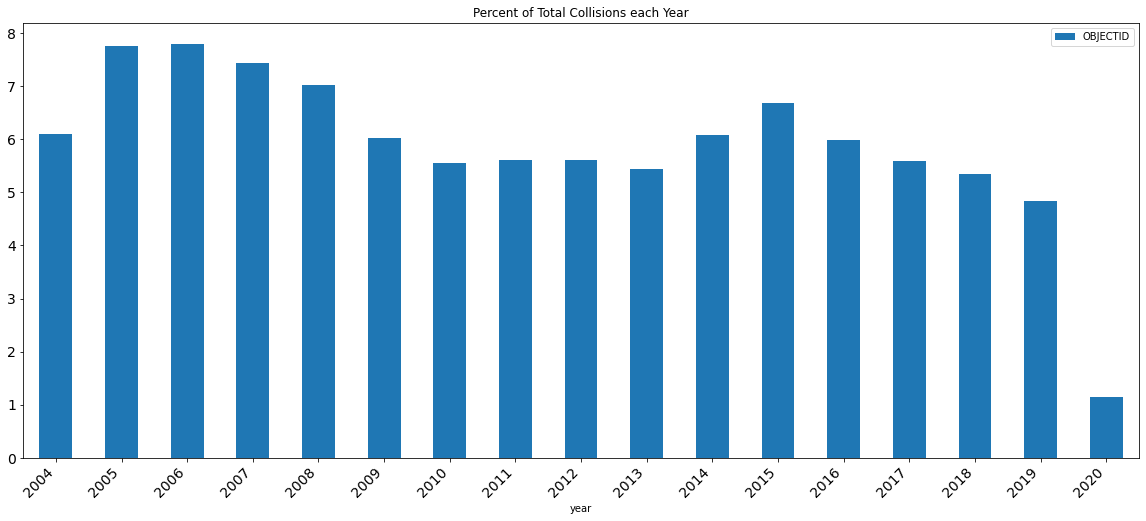

In [10]:

df_yr.plot(kind="bar", figsize=(20, 8))
plt.title("Percent of Total Collisions each Year")
plt.xticks(rotation=45, ha="right", size=14)
plt.yticks(size=14)
plt.show()


In [11]:

# removing year 2020 records as it has too few values/accidents recorded to train the dataset
df = df[df["year"] != 2020]
df_inattentionind_counts = df["INATTENTIONIND"].value_counts()
collisions_due_to_inattention = "INATTENTIONIND", df_inattentionind_counts.to_frame(
    "count"
)
print(f"{collisions_due_to_inattention} collisions due to inattention")
df["INATTENTIONIND"].replace(np.nan, 0, inplace=True)
df["INATTENTIONIND"].replace("Y", 1, inplace=True)
df[["INATTENTIONIND"]] = df[["INATTENTIONIND"]].astype("int")


('INATTENTIONIND',    count
Y  29805) collisions due to inattention


In [12]:

df_underinfl_counts = df["UNDERINFL"].value_counts()
collisions_due_to_underinfl = "UNDERINFL", df_underinfl_counts.to_frame("count")
print(
    f"{collisions_due_to_underinfl} collision due to under influence of drugs or alcohol."
)
df["UNDERINFL"].replace(np.nan, 0, inplace=True)
df["UNDERINFL"].replace("N", 0, inplace=True)
df["UNDERINFL"].replace("Y", 1, inplace=True)
df[["UNDERINFL"]] = df[["UNDERINFL"]].astype("int")


('UNDERINFL',    count
N  99013
0  80394
Y   5126
1   3995) collision due to under influence of drugs or alcohol.


In [13]:

df_ped_not_granted_counts = df["PEDROWNOTGRNT"].value_counts()
ped_not_granted = "PEDROWNOTGRNT", df_ped_not_granted_counts.to_frame("count")
print(f"{ped_not_granted} collisions where pedestrian right of way was not granted")
df["PEDROWNOTGRNT"].replace(np.nan, 0, inplace=True)
df["PEDROWNOTGRNT"].replace("Y", 1, inplace=True)
df[["PEDROWNOTGRNT"]] = df[["PEDROWNOTGRNT"]].astype("int")


('PEDROWNOTGRNT',    count
Y   4631) collisions where pedestrian right of way was not granted


In [14]:

df_speeding_counts = df["SPEEDING"].value_counts()
driver_speeding = "SPEEDING", df_speeding_counts.to_frame("count")
print(f"{driver_speeding} collisions where the driver was speeding")
df["SPEEDING"].replace(np.nan, 0, inplace=True)
df["SPEEDING"].replace("Y", 1, inplace=True)
df[["SPEEDING"]] = df[["SPEEDING"]].astype("int")


('SPEEDING',    count
Y   9261) collisions where the driver was speeding


In [15]:

df_hit_parked_car_counts = df["HITPARKEDCAR"].value_counts()
hit_parked_car = "HITPARKEDCAR", df_hit_parked_car_counts.to_frame("count")
print(f"{hit_parked_car} collisions where a parked car was hit")
df["HITPARKEDCAR"].replace("N", 0, inplace=True)
df["HITPARKEDCAR"].replace("Y", 1, inplace=True)
df[["HITPARKEDCAR"]] = df[["HITPARKEDCAR"]].astype("int")


('HITPARKEDCAR',     count
N  185524
Y    6904) collisions where a parked car was hit


In [16]:

df["LIGHTCOND"].replace("Other", "Unknown", inplace=True)
df["LIGHTCOND"].replace(np.nan, "Unknown", inplace=True)
df_light_cond_counts = df["LIGHTCOND"].value_counts()
daylight_collisions = "LIGHTCOND", df_light_cond_counts.to_frame("count")
print(f"{daylight_collisions} collisions in daylight")
df["LIGHTCOND"].isna().sum()
df["LIGHTCOND"].replace("Dusk", "Low Light", inplace=True)
df["LIGHTCOND"].replace("Dawn", "Low Light", inplace=True)
df["LIGHTCOND"].replace("Dark - No Street Lights", "Dark", inplace=True)
df["LIGHTCOND"].replace("Dark - Street Lights On", "Dark", inplace=True)
df["LIGHTCOND"].replace("Dark - Street Lights Off", "Dark", inplace=True)


('LIGHTCOND',                            count
Daylight                  115407
Dark - Street Lights On    48104
Unknown                    17860
Dusk                        5862
Dawn                        2480
Dark - No Street Lights     1522
Dark - Street Lights Off    1193) collisions in daylight


highest number of collisions in daylight


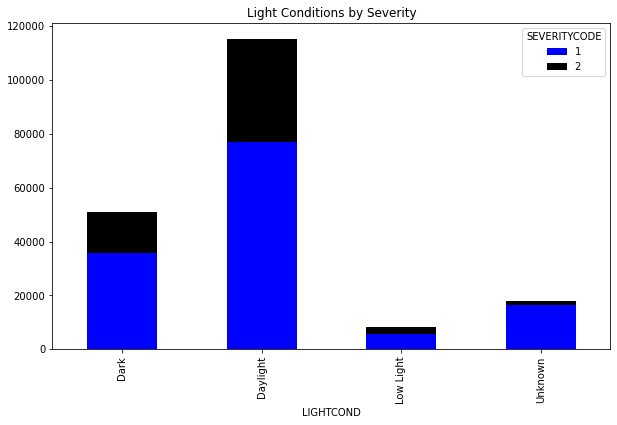

In [17]:

plot_by_severity_code = df.pivot_table(
    index="LIGHTCOND", columns="SEVERITYCODE", aggfunc="size"
).plot
plot_by_severity_code.bar(stacked=True, color=("b", "#000000"), figsize=(10, 6))
plt.title("Light Conditions by Severity")
print("highest number of collisions in daylight")


Text(0.5, 1.0, 'Light Conditions by Hour')

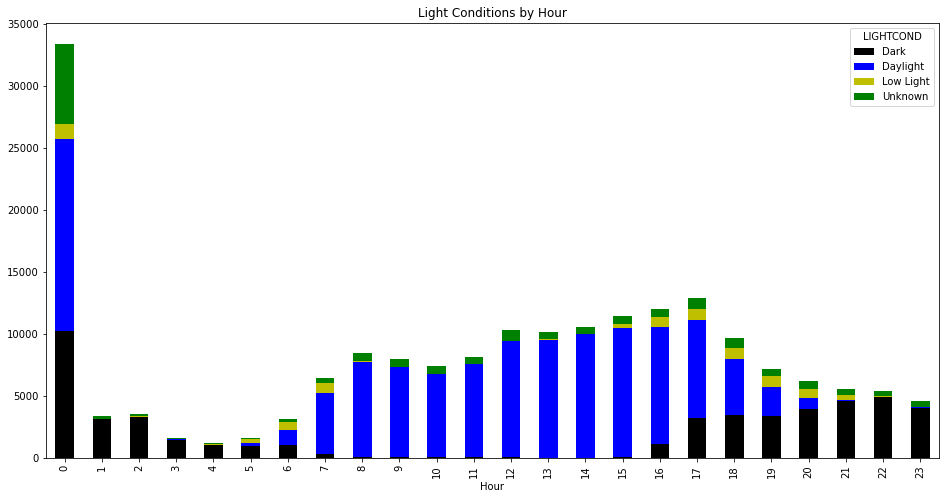

In [18]:

plot_by_hour = df.pivot_table(index=("Hour"), columns="LIGHTCOND", aggfunc="size").plot
plot_by_hour.bar(stacked=True, color=("#000000", "b", "y", "g"), figsize=(16, 8))
plt.title("Light Conditions by Hour")


Text(0.5, 1.0, 'Light Conditions by Hour')

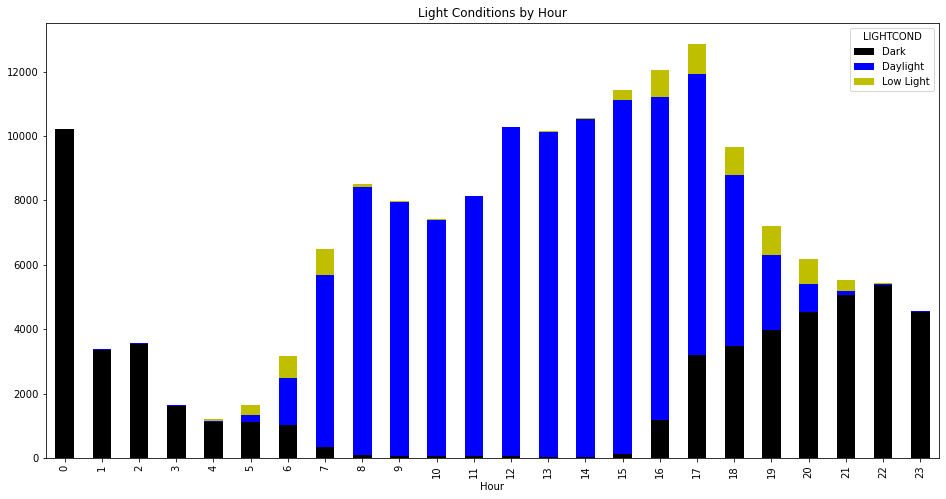

In [19]:

df = df[((df["Hour"] == 0) & (df["LIGHTCOND"] == "Dark")) | (df["Hour"] != 0)]
df.loc[
    df["Hour"].isin([0, 1, 2, 3, 4, 5, 19, 20, 21, 22, 23])
    & (df["LIGHTCOND"] == "Unknown"),
    "LIGHTCOND",
] = "Dark"
df.loc[
    (df["Hour"] >= 6) & (df["Hour"] <= 18) & (df["LIGHTCOND"] == "Unknown"), "LIGHTCOND"
] = "Daylight"
second_plot_by_hour = df.pivot_table(
    index=("Hour"), columns="LIGHTCOND", aggfunc="size"
).plot
second_plot_by_hour.bar(stacked=True, color=("#000000", "b", "y", "g"), figsize=(16, 8))
plt.title("Light Conditions by Hour")


Text(0.5, 1.0, 'Light Conditions by Severity')

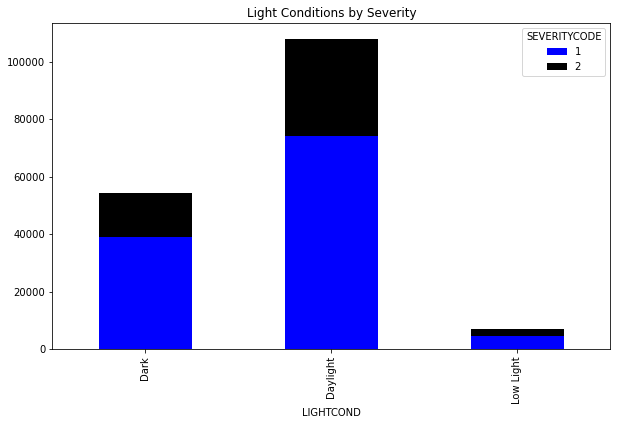

In [20]:

second_plot_by_severity_code = df.pivot_table(
    index="LIGHTCOND", columns="SEVERITYCODE", aggfunc="size"
).plot
second_plot_by_severity_code.bar(stacked=True, color=("b", "#000000"), figsize=(10, 6))
plt.title("Light Conditions by Severity")


In [21]:

# replace other and nulls with unknown
df["WEATHER"].replace(np.nan, "Unknown", inplace=True)
df["WEATHER"].replace("Other", "Unknown", inplace=True)
print("WEATHER", df["WEATHER"].value_counts().to_frame("count"))
print("Unknown", df["WEATHER"].isna().sum())


WEATHER                           count
Clear                     99299
Raining                   30161
Overcast                  24651
Unknown                   13649
Snowing                     806
Fog/Smog/Smoke              547
Sleet/Hail/Freezing Rain     99
Blowing Sand/Dirt            51
Severe Crosswind             25
Unknown 0


Text(0.5, 1.0, 'Weather by Severity')

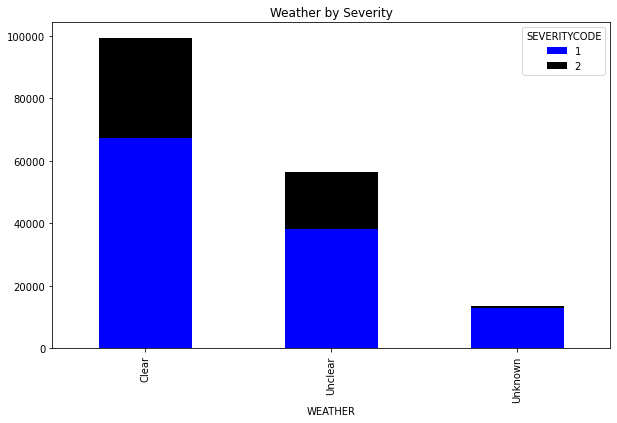

In [22]:

df.loc[(df["WEATHER"] != "Clear") & (df["WEATHER"] != "Unknown"), "WEATHER"] = "Unclear"
plot_weather_by_severity = df.pivot_table(
    index="WEATHER", columns="SEVERITYCODE", aggfunc="size"
).plot
plot_weather_by_severity.bar(stacked=True, color=("b", "#000000"), figsize=(10, 6))
plt.title("Weather by Severity")
# most collisions happen in clear or unclear weather with larger number of SEVERITYCODE  1 and 2 both happening in clear weather


Text(0.5, 1.0, 'Weather across Month')

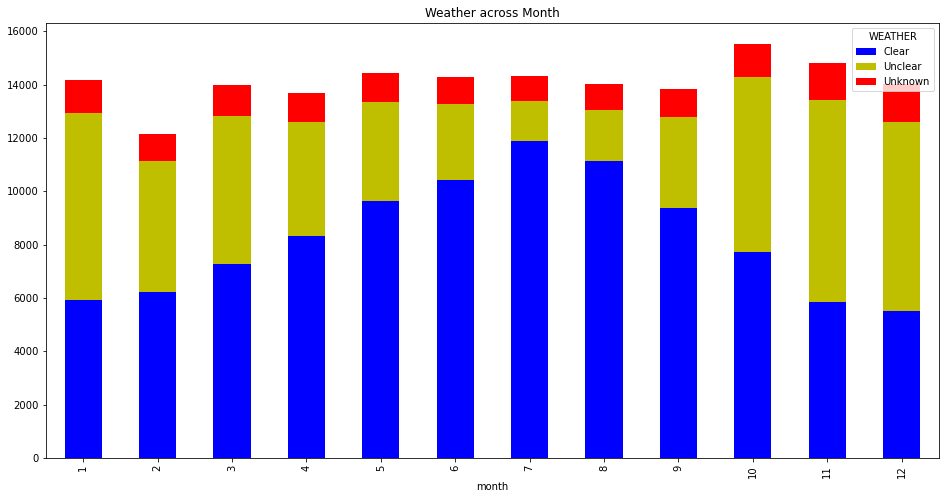

In [23]:

# how is weather in Seattle across the year
plot_weather_across_month = df.pivot_table(
    index=("month"), columns="WEATHER", aggfunc="size"
).plot
plot_weather_across_month.bar(stacked=True, color=("b", "y", "r"), figsize=(16, 8))
plt.title("Weather across Month")


Text(0.5, 1.0, 'Weather by Severity')

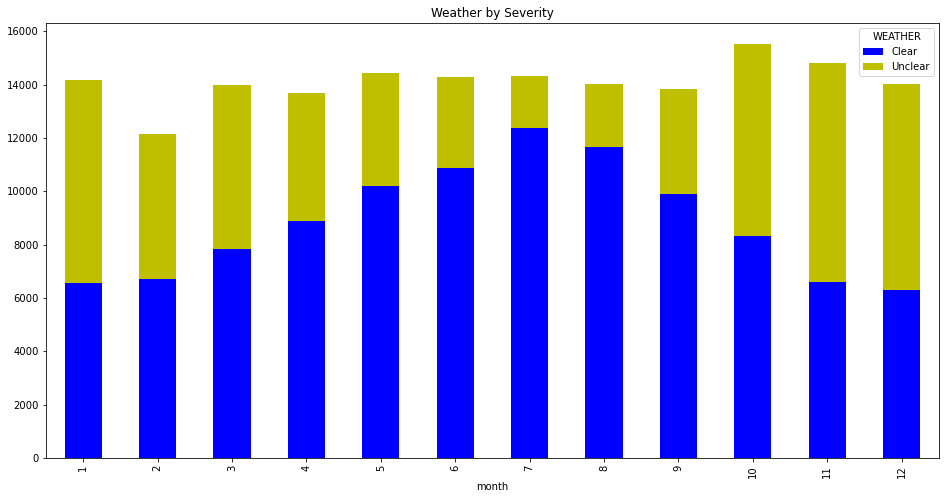

In [24]:

# assuming that weather will be same on day across Seattle. so replace the data where weather is unknown with the datadata where weather is not unknown and dates are matching
df_notnull = df.loc[df["WEATHER"] != "Unknown"]
df_notnull = df_notnull[["INCDATE", "WEATHER"]]
df_notnull.drop_duplicates(inplace=True)
df_notnull.set_index("INCDATE", inplace=True)
s = df_notnull.to_dict()["WEATHER"]
df.loc[df["WEATHER"] == "Unknown", "WEATHER"] = df[("INCDATE")].map(s)
df = df[df["WEATHER"].notna()]
plot_weather_by_severity2 = df.pivot_table(
    index=("month"), columns="WEATHER", aggfunc="size"
).plot
plot_weather_by_severity2.bar(stacked=True, color=("b", "y", "r"), figsize=(16, 8))
plt.title("Weather by Severity")


Text(0.5, 1.0, 'Weather by Severity')

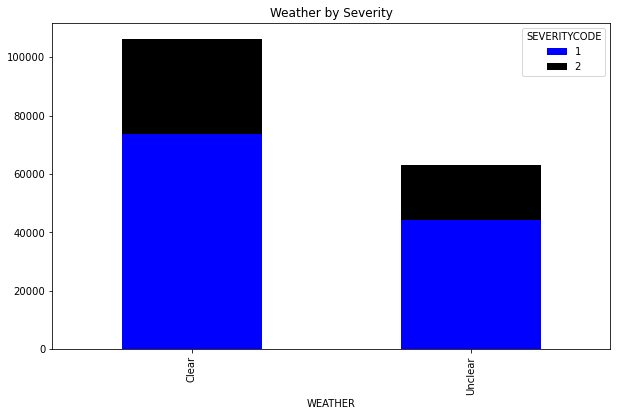

In [25]:

plot_weather_by_severity3 = df.pivot_table(
    index="WEATHER", columns="SEVERITYCODE", aggfunc="size"
).plot
plot_weather_by_severity3.bar(stacked=True, color=("b", "#000000"), figsize=(10, 6))
plt.title("Weather by Severity")


In [26]:

df["ROADCOND"].replace(np.nan, "Unknown", inplace=True)
df["ROADCOND"].replace("Other", "Unknown", inplace=True)
print("ROADCOND", df["ROADCOND"].value_counts().to_frame("count"))
print("Unknown", df["ROADCOND"].isna().sum())
print("roads are mostly dry")


ROADCOND                  count
Dry             110988
Wet              43042
Unknown          13020
Ice               1112
Snow/Slush         899
Standing Water     103
Sand/Mud/Dirt       64
Oil                 57
Unknown 0
roads are mostly dry


Text(0.5, 1.0, 'Road Conditions by Severity')

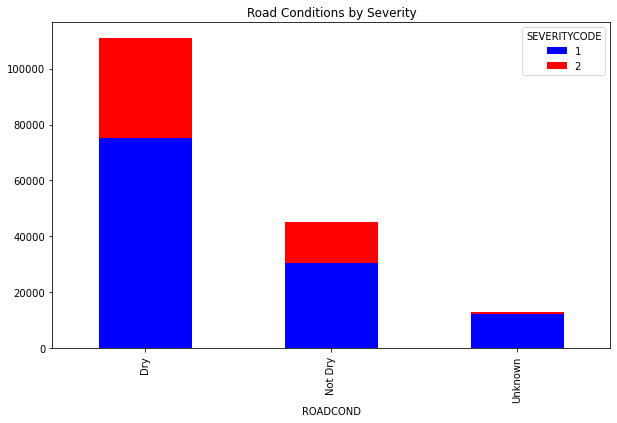

In [27]:

# classify wet road condition as not dry
df.loc[
    (df["ROADCOND"] != "Dry") & (df["ROADCOND"] != "Unknown"), "ROADCOND"
] = "Not Dry"
plot_road_condition = df.pivot_table(
    index="ROADCOND", columns="SEVERITYCODE", aggfunc="size"
).plot
plot_road_condition.bar(stacked=True, color=("b", "r"), figsize=(10, 6))
plt.title("Road Conditions by Severity")


In [28]:

# creating a key with date and location
df["Key1"] = df["INCDATE"].astype(str) + df["LOCATION"]
# using the key let's replace unknown
df_notnull = df.loc[df["ROADCOND"] != "Unknown"]
df_notnull = df_notnull[["Key1", "ROADCOND"]]
df_notnull.drop_duplicates(inplace=True)
df_notnull.set_index("Key1", inplace=True)
s = df_notnull.to_dict()["ROADCOND"]
df.loc[df["ROADCOND"] == "Unknown", "ROADCOND"] = df[("Key1")].map(s)
df["ROADCOND"].replace(np.nan, "Unknown", inplace=True)
print("ROADCOND", df["ROADCOND"].value_counts().to_frame("count"))
print("Unknown", df["ROADCOND"].isna().sum())


ROADCOND           count
Dry      111033
Not Dry   46307
Unknown   11945
Unknown 0


Text(0.5, 1.0, 'Road Conditions by Month')

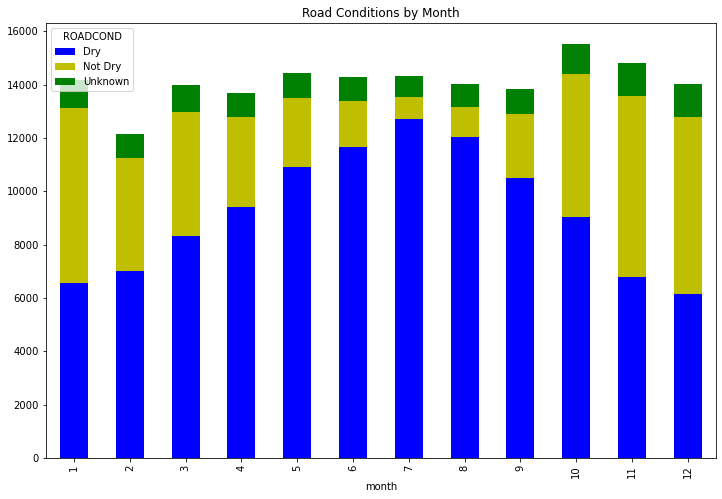

In [29]:

plot_road_condition_by_month = df.pivot_table(
    index=("month"), columns="ROADCOND", aggfunc="size"
).plot
plot_road_condition_by_month.bar(stacked=True, color=("b", "y", "g"), figsize=(12, 8))
plt.title("Road Conditions by Month")


roads are dry during the middle of the year. mostly wet from october to january


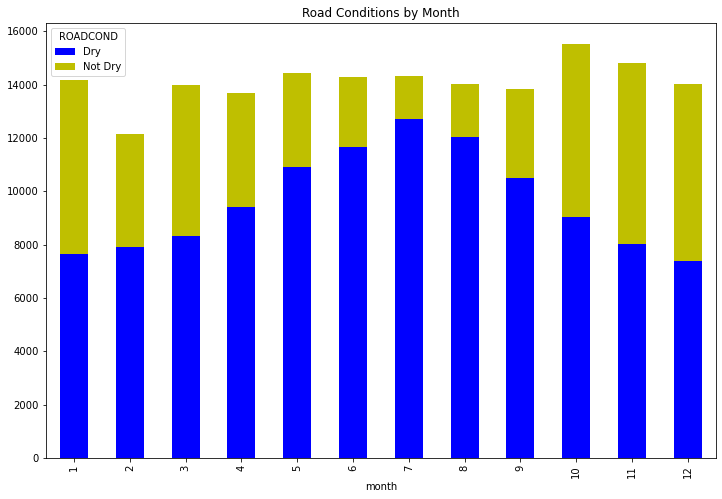

In [30]:

# as road conditions are dry and not dry, we can say that road in Seattle are mostly dry during match to oct. with this assumption let's remove the nulls/unknowns
df.loc[
    df["month"].isin([1, 2, 11, 12]) & (df["ROADCOND"] == "Unknown"), "ROADCOND"
] = "Dry"
df.loc[
    (df["month"] >= 3) & (df["month"] <= 10) & (df["ROADCOND"] == "Unknown"), "ROADCOND"
] = "Not Dry"
dry_not_dry_plot = df.pivot_table(
    index=("month"), columns="ROADCOND", aggfunc="size"
).plot
dry_not_dry_plot.bar(stacked=True, color=("b", "y", "g"), figsize=(12, 8))
plt.title("Road Conditions by Month")
print("roads are dry during the middle of the year. mostly wet from october to january")


majority of accidents are happening on dry roads


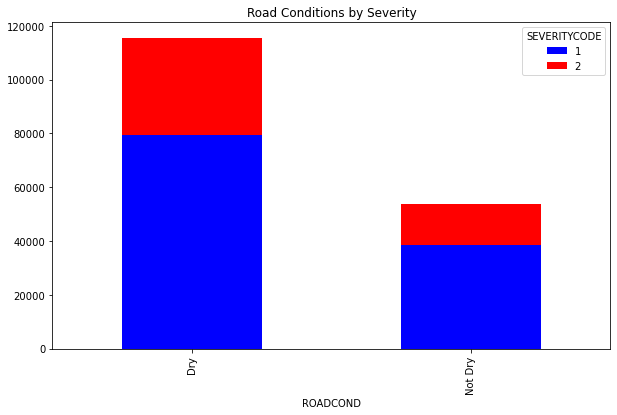

In [31]:

severity_by_dry_not_dry = df.pivot_table(
    index="ROADCOND", columns="SEVERITYCODE", aggfunc="size"
).plot
severity_by_dry_not_dry.bar(stacked=True, color=("b", "r"), figsize=(10, 6))
plt.title("Road Conditions by Severity")
print("majority of accidents are happening on dry roads")


In [32]:

# there are lots of other data in collision type, only 21 unknowns let's get rid of it
print("COLLISIONTYPE", df["COLLISIONTYPE"].value_counts().to_frame("count"))
print("Unknown", df["COLLISIONTYPE"].isna().sum())
df = df[df["COLLISIONTYPE"].notna()]


COLLISIONTYPE             count
Parked Car  42335
Angles      31100
Rear Ended  30277
Other       21085
Sideswipe   16637
Left Turn   12351
Pedestrian   6068
Cycles       4937
Right Turn   2626
Head On      1848
Unknown 21


<AxesSubplot:xlabel='ST_COLCODE'>

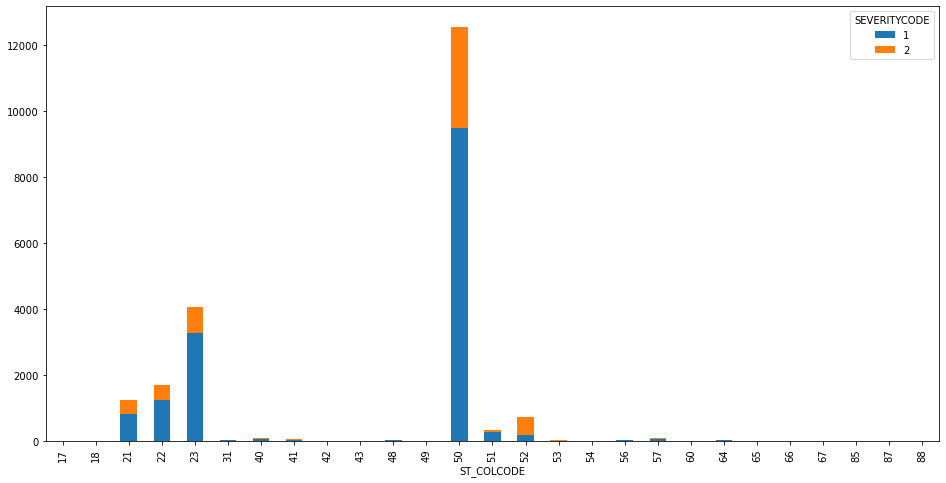

In [33]:

# let's use ST_COLCODE to fill other value, first let's map the records where collision type as other with ST_COLCODE
dfcollision = df[(df["COLLISIONTYPE"] == "Other")]
dfcollision = dfcollision[["ST_COLCODE", "COLLISIONTYPE", "SEVERITYCODE"]]
dfcollision.reset_index(inplace=True, drop=True)
dfcollision = dfcollision[dfcollision["ST_COLCODE"].notna()]
dfcollision = dfcollision[dfcollision["ST_COLCODE"] != " "]
# dfcollision.drop_duplicates(inplace=True)
dfcollision[["ST_COLCODE"]] = dfcollision[["ST_COLCODE"]].astype("int")
plot_severit_by_st_colcode = dfcollision.pivot_table(
    index=("ST_COLCODE"), columns="SEVERITYCODE", aggfunc="size"
).plot
plot_severit_by_st_colcode.bar(stacked=True, figsize=(16, 8))


In [34]:

print(dfcollision["ST_COLCODE"].unique())


[23 22 51 50 21 52 66 40 57 56 41 17 67 49 31 65 42 48 64 53 54 60 43 87
 85 88 18]


severity 1 happened mostly against parked cars while severity 2 was collision at angles or rear ended


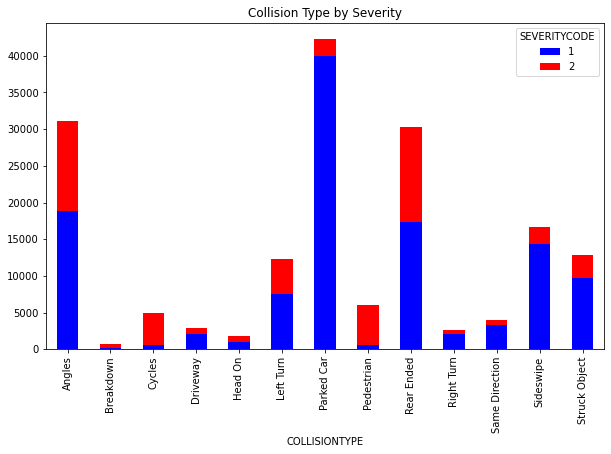

In [35]:

# there are few colcodes which we can use, based on metadata we will now replace collision type with correct values
df = df[df["ST_COLCODE"].notna()]
df = df[df["ST_COLCODE"] != " "]
df[["ST_COLCODE"]] = df[["ST_COLCODE"]].astype("int")
# dropping these which are not in metadata or contain very less data
df = df[
    ~df["ST_COLCODE"].isin(
        [17,18,31,40,41,42,43,48,49,53,54,56,57,60,64,65,66,67,85,87,88]
    )
]
df.loc[df["ST_COLCODE"].isin([51, 50]), "COLLISIONTYPE"] = "Struck Object"
df.loc[df["ST_COLCODE"].isin([21, 22]), "COLLISIONTYPE"] = "Driveway"
df.loc[df["ST_COLCODE"].isin([52]), "COLLISIONTYPE"] = "Breakdown"
df.loc[df["ST_COLCODE"].isin([23]), "COLLISIONTYPE"] = "Same Direction"
df.drop(columns=["ST_COLCODE"], axis=1, inplace=True)
plot_collision_by_severity = df.pivot_table(
    index="COLLISIONTYPE", columns="SEVERITYCODE", aggfunc="size"
).plot
plot_collision_by_severity.bar(stacked=True, color=("b", "r"), figsize=(10, 6))
plt.title("Collision Type by Severity")
print(
    "severity 1 happened mostly against parked cars while severity 2 was collision at angles or rear ended"
)


In [36]:

# looking at the address field. replacing null values
df["ADDRTYPE"].replace(np.nan, "Unknown", inplace=True)
df_notnull = df.loc[df["ADDRTYPE"] != "Unknown"]
df_notnull = df_notnull[["LOCATION", "ADDRTYPE"]]
df_notnull.drop_duplicates(inplace=True)
df_notnull.set_index("LOCATION", inplace=True)
s = df_notnull.to_dict()["ADDRTYPE"]
df.loc[df["ADDRTYPE"] == "Unknown", "ADDRTYPE"] = df[("LOCATION")].map(s)
print("ADDRTYPE", df["ADDRTYPE"].value_counts().to_frame("count"))
print("is null", df["ADDRTYPE"].isna().sum())


ADDRTYPE                count
Block         109581
Intersection   56961
Alley           2246
is null 0


Text(0.5, 1.0, 'Address Type by Severity')

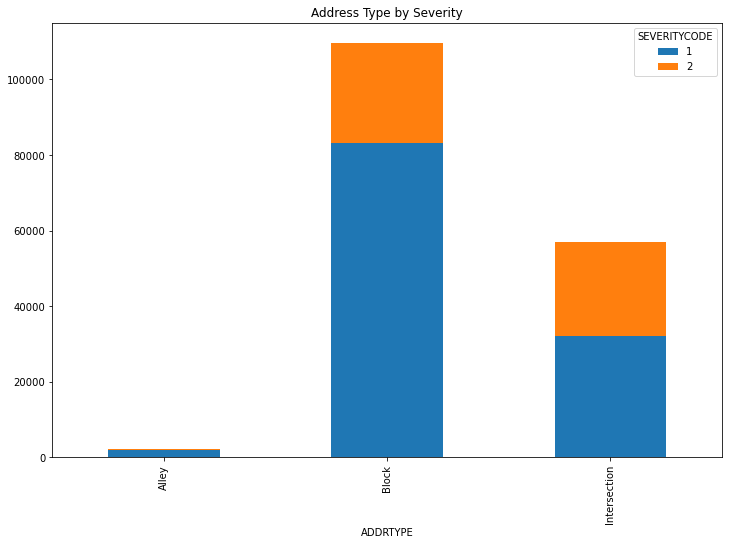

In [37]:

plot_address_by_severity = df.pivot_table(
    index=("ADDRTYPE"), columns="SEVERITYCODE", aggfunc="size"
).plot
plot_address_by_severity.bar(stacked=True, figsize=(12, 8))
plt.title("Address Type by Severity")


In [38]:

df["JUNCTIONTYPE"].replace(np.nan, "Unknown", inplace=True)
print("JUNCTIONTYPE", df["JUNCTIONTYPE"].value_counts().to_frame("count"))
print("Unknown", df["JUNCTIONTYPE"].isna().sum())


JUNCTIONTYPE                                                    count
Mid-Block (not related to intersection)            77983
At Intersection (intersection related)             54891
Mid-Block (but intersection related)               19244
Driveway Junction                                   8939
Unknown                                             5655
At Intersection (but not related to intersection)   1920
Ramp Junction                                        156
Unknown 0


highest cases of severity 1 at non intersection. highest cases of severity 2 at intersection


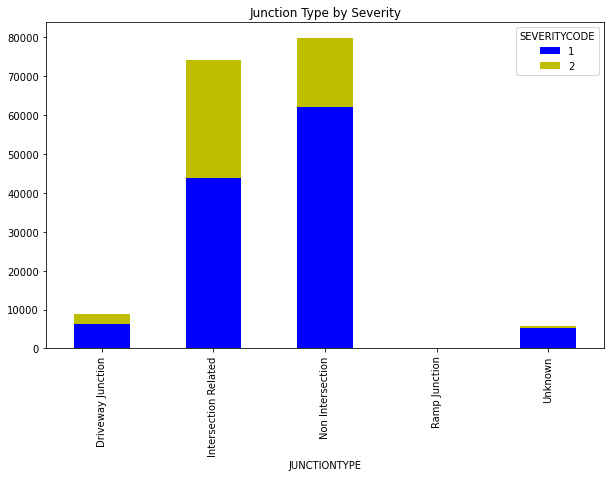

In [39]:

df["JUNCTIONTYPE"] = df["JUNCTIONTYPE"].replace(
    {
        "Mid-Block (not related to intersection)": "Non Intersection",
        "At Intersection (intersection related)": "Intersection Related",
        "Mid-Block (but intersection related)": "Intersection Related",
        "At Intersection (but not related to intersection)": "Non Intersection",
        np.nan: "Unknown",
    }
)
plot_junction_by_severity = df.pivot_table(
    index=("JUNCTIONTYPE"), columns="SEVERITYCODE", aggfunc="size"
).plot
plot_junction_by_severity.bar(stacked=True, color=("b", "y"), figsize=(10, 6))
plt.title("Junction Type by Severity")
print(
    "highest cases of severity 1 at non intersection. highest cases of severity 2 at intersection"
)


In [40]:

df_notnull = df.loc[df["JUNCTIONTYPE"] != "Unknown"]
df_notnull = df_notnull[["LOCATION", "JUNCTIONTYPE"]]
df_notnull.drop_duplicates(inplace=True)
df_notnull.set_index("LOCATION", inplace=True)
s = df_notnull.to_dict()["JUNCTIONTYPE"]
df.loc[df["JUNCTIONTYPE"] == "Unknown", "JUNCTIONTYPE"] = df[("LOCATION")].map(s)
print("JUNCTIONTYPE", df["JUNCTIONTYPE"].value_counts().to_frame("count"))
print("is null", df["JUNCTIONTYPE"].isna().sum())
df["JUNCTIONTYPE"].replace(np.nan, "Unknown", inplace=True)


JUNCTIONTYPE                       count
Non Intersection      81540
Intersection Related  75215
Driveway Junction      9740
Ramp Junction          1998
is null 295


Text(0.5, 1.0, 'Junction Type by Severity')

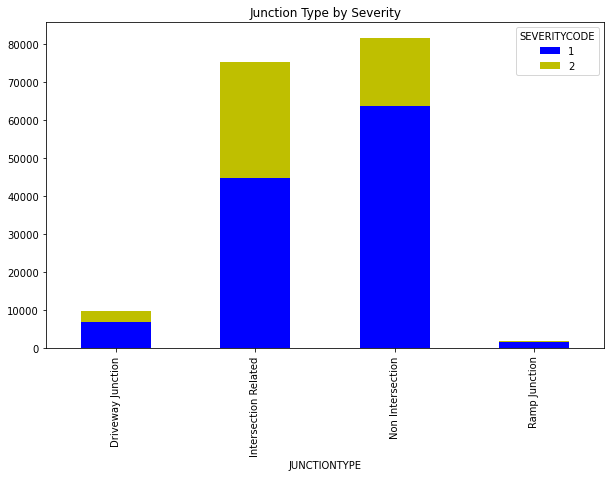

In [41]:

df = df[df["JUNCTIONTYPE"] != "Unknown"]
plot_junction_by_severity_replaced = df.pivot_table(
    index=("JUNCTIONTYPE"), columns="SEVERITYCODE", aggfunc="size"
).plot
plot_junction_by_severity_replaced.bar(stacked=True, color=("b", "y"), figsize=(10, 6))
plt.title("Junction Type by Severity")


In [42]:
# dropping the key set earlier
df.drop(["Key1"], axis=1, inplace=True)
seattle_map = folium.Map(location=[47.6062, -122.3321], zoom_start=12)
accident_df = df.loc[
    (df["X"].notna())
    & (df["year"] == 2016)
    & (df["month"].isin([6, 7, 8, 9, 10, 11, 12]))
]
accident_df = accident_df[["X", "Y", "SEVERITYCODE", "year"]]
accident_df["SEVERITYCODE"] = accident_df["SEVERITYCODE"].astype(str)
print(accident_df.shape)
incidents = folium.map.FeatureGroup()
for lat, lng, label in zip(accident_df.Y, accident_df.X, accident_df.SEVERITYCODE):
    if label == "1":
        folium.features.Marker([lat, lng], radius=2, color="blue").add_to(seattle_map)
    else:
        folium.features.Marker([lat, lng], radius=2, color="red").add_to(seattle_map)
seattle_map.save("seattle_map.html")
display(seattle_map)


(6194, 4)


<AxesSubplot:>

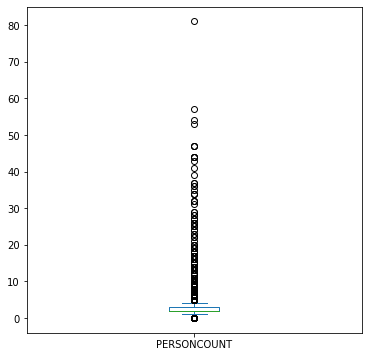

In [43]:

# let's drop the location. from the visualization it is evident that at a loction both types of accidents may occur. we shall not use X & Y as features
df.drop(["LOCATION"], axis=1, inplace=True)
df = df.loc[(df["X"].notna())]
# box plot person count, in summary above there are lots of unique values
df["PERSONCOUNT"].plot(kind="box", figsize=(6, 6))


SEVERITYCODE             1      2
PERSONCOUNT-binned               
Low                 113640  50272
Medium                  23      5
High                     1      1

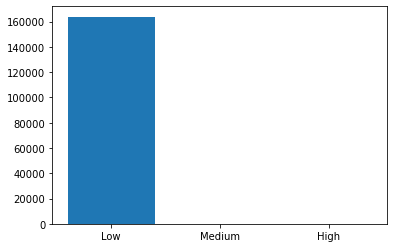

In [44]:

# there are lots of outliers, let's bin it and visualize
bins = np.linspace(min(df["PERSONCOUNT"]), max(df["PERSONCOUNT"]), 4)
group_names = ["Low", "Medium", "High"]
df["PERSONCOUNT-binned"] = pd.cut(
    df["PERSONCOUNT"], bins, labels=group_names, include_lowest=True
)
plt.bar(group_names, df["PERSONCOUNT-binned"].value_counts())
pd.crosstab(df["PERSONCOUNT-binned"], df["SEVERITYCODE"])


In [45]:

# as the binning showed that most of the data is in lowest bin and can't be used to determine severity (from the crosstab results)
df.drop(["PERSONCOUNT", "PERSONCOUNT-binned"], axis=1, inplace=True)
# let's take a loot a pedcount, many accident's don't involve pedesterians, but even if 1 pedest is invloved the risk of higher severity increases
pd.crosstab(df["PEDCOUNT"], df["SEVERITYCODE"])


SEVERITYCODE       1      2
PEDCOUNT                   
0             113025  44594
1                623   5463
2                 15    196
3                  1     19
4                  0      4
5                  0      1
6                  0      1

In [46]:
numerical_features = df.select_dtypes(include=["number"])
numerical_features.drop(columns=["X", "Y", "OBJECTID", "year", "day"], inplace=True)
# calulate P values for the numerical features
col_name = numerical_features.columns
df_local_list = []
for i in enumerate(col_name):
    column_name = col_name[i[0]]
    pearson_coef, p_value = stats.pearsonr(df[column_name], df["SEVERITYCODE"])
    the_values = [
        {
            "Column Name": column_name,
            "Pearson Correlation Coefficient": pearson_coef,
            "P-value of": p_value,
        }
    ]
    pass_to_df = pd.DataFrame.from_dict(the_values)
    df_local_list.append(pass_to_df)
percof_smry = pd.concat(df_local_list, ignore_index=True)
print(percof_smry)

       Column Name  Pearson Correlation Coefficient     P-value of
0     SEVERITYCODE                         1.000000   0.000000e+00
1         PEDCOUNT                         0.251263   0.000000e+00
2      PEDCYLCOUNT                         0.217310   0.000000e+00
3         VEHCOUNT                        -0.088294  5.464418e-281
4   INATTENTIONIND                         0.040824   2.016460e-61
5        UNDERINFL                         0.043036   4.618621e-68
6    PEDROWNOTGRNT                         0.208156   0.000000e+00
7         SPEEDING                         0.038203   5.226122e-54
8     HITPARKEDCAR                        -0.106021   0.000000e+00
9            month                         0.004751   5.437663e-02
10       dayofweek                        -0.017850   4.910711e-13
11            Hour                         0.024883   7.009487e-24


In [47]:

categorical_features = df.select_dtypes(
    exclude=[np.number, np.datetime64]
)  # .columns.tolist()
char_value = categorical_features.columns
print(char_value)


Index(['ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND',
       'LIGHTCOND'],
      dtype='object')



### ANOVA: Analysis of Variance
<p>The Analysis of Variance  (ANOVA) is a statistical method used to test whether there are significant differences between the means of two or more groups. ANOVA returns two parameters:</p>

<p><b>F-test score</b>: ANOVA assumes the means of all groups are the same, calculates how much the actual means deviate from the assumption, and reports it as the F-test score. A larger score means there is a larger difference between the means.</p>

<p><b>P-value</b>:  P-value tells how statistically significant is our calculated score value.</p>
<p>large F test score showing a strong correlation and a P value of almost 0 implying almost certain statistical significance. expect ANOVA to return a sizeable F-test score and a small p-value.</p>
<p>let's calculate avonva score for all categorical features.</p>


In [48]:

grouped_test = df[["LIGHTCOND", "SEVERITYCODE"]].groupby(["LIGHTCOND"])
f_val, p_val = stats.f_oneway(
    grouped_test.get_group("Daylight")["SEVERITYCODE"],
    grouped_test.get_group("Dark")["SEVERITYCODE"],
    grouped_test.get_group("Low Light")["SEVERITYCODE"],
)
# listify the dict
appendify = []
anova_listify = [{"Column Name": "LIGHTCOND", "F Value": f_val, "P value": p_val}]
framify = pd.DataFrame(anova_listify)
appendify.append(framify)
ANOVA_smry = pd.concat(appendify, ignore_index=True)

grouped_test = df[["ADDRTYPE", "SEVERITYCODE"]].groupby(["ADDRTYPE"])
f_val, p_val = stats.f_oneway(
    grouped_test.get_group("Intersection")["SEVERITYCODE"],
    grouped_test.get_group("Block")["SEVERITYCODE"],
)
anova_listify = [{"Column Name": "ADDRTYPE", "F Value": f_val, "P value": p_val}]
framify = pd.DataFrame(anova_listify)
appendify.append(framify)
ANOVA_smry = pd.concat(appendify, ignore_index=True)

grouped_test = df[["COLLISIONTYPE", "SEVERITYCODE"]].groupby(["COLLISIONTYPE"])
f_val, p_val = stats.f_oneway(
    grouped_test.get_group("Angles")["SEVERITYCODE"],
    grouped_test.get_group("Sideswipe")["SEVERITYCODE"],
    grouped_test.get_group("Parked Car")["SEVERITYCODE"],
    grouped_test.get_group("Rear Ended")["SEVERITYCODE"],
    grouped_test.get_group("Head On")["SEVERITYCODE"],
    grouped_test.get_group("Left Turn")["SEVERITYCODE"],
    grouped_test.get_group("Right Turn")["SEVERITYCODE"],
    grouped_test.get_group("Cycles")["SEVERITYCODE"],
    grouped_test.get_group("Driveway")["SEVERITYCODE"],
    grouped_test.get_group("Pedestrian")["SEVERITYCODE"],
    grouped_test.get_group("Breakdown")["SEVERITYCODE"],
    grouped_test.get_group("Same Direction")["SEVERITYCODE"],
    grouped_test.get_group("Struck Object")["SEVERITYCODE"],
)
anova_listify = [{"Column Name": "COLLISIONTYPE", "F Value": f_val, "P value": p_val}]
framify = pd.DataFrame(anova_listify)
appendify.append(framify)
ANOVA_smry = pd.concat(appendify, ignore_index=True)

grouped_test = df[["JUNCTIONTYPE", "SEVERITYCODE"]].groupby(["JUNCTIONTYPE"])
f_val, p_val = stats.f_oneway(
    grouped_test.get_group("Non Intersection")["SEVERITYCODE"],
    grouped_test.get_group("Intersection Related")["SEVERITYCODE"],
    grouped_test.get_group("Ramp Junction")["SEVERITYCODE"],
    grouped_test.get_group("Driveway Junction")["SEVERITYCODE"],
)
anova_listify = [{"Column Name": "JUNCTIONTYPE", "F Value": f_val, "P value": p_val}]
framify = pd.DataFrame(anova_listify)
appendify.append(framify)
ANOVA_smry = pd.concat(appendify, ignore_index=True)

grouped_test = df[["WEATHER", "SEVERITYCODE"]].groupby(["WEATHER"])
f_val, p_val = stats.f_oneway(
    grouped_test.get_group("Clear")["SEVERITYCODE"],
    grouped_test.get_group("Unclear")["SEVERITYCODE"],
)
anova_listify = [{"Column Name": "WEATHER", "F Value": f_val, "P value": p_val}]
framify = pd.DataFrame(anova_listify)
appendify.append(framify)
ANOVA_smry = pd.concat(appendify, ignore_index=True)

grouped_test = df[["ROADCOND", "SEVERITYCODE"]].groupby(["ROADCOND"])
f_val, p_val = stats.f_oneway(
    grouped_test.get_group("Dry")["SEVERITYCODE"],
    grouped_test.get_group("Not Dry")["SEVERITYCODE"]
)
anova_listify = [{"Column Name": "ROADCOND", "F Value": f_val, "P value": p_val}]
framify = pd.DataFrame(anova_listify)
appendify.append(framify)
ANOVA_smry = pd.concat(appendify, ignore_index=True)

print(ANOVA_smry)

     Column Name      F Value       P value
0      LIGHTCOND   113.296989  6.756411e-50
1       ADDRTYPE  6929.297391  0.000000e+00
2  COLLISIONTYPE  3892.866144  0.000000e+00
3   JUNCTIONTYPE  2216.275852  0.000000e+00
4        WEATHER    14.132951  1.703928e-04
5       ROADCOND   119.806061  7.132669e-28


In [49]:

# based on p values using pearce coefficient and avanova let's drop the below colums
df.drop(
    columns=[
        "OBJECTID",
        "year",
        "day",
        "WEATHER",
        "PEDCOUNT",
        "PEDCYLCOUNT",
        "PEDROWNOTGRNT",
        "HITPARKEDCAR",
        "month",
        "INCDATE",
        "INCDTTM",
        "LIGHTCOND",
        "ROADCOND",
    ],
    axis=1,
    inplace=True,
)
df.drop(columns=["X", "Y"], axis=1, inplace=True)
print(df.columns)


Index(['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'VEHCOUNT', 'JUNCTIONTYPE',
       'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'dayofweek', 'Hour'],
      dtype='object')


In [50]:

# feature selection and correlation
Feature = df[
    [
        "SEVERITYCODE",
        "ADDRTYPE",
        "COLLISIONTYPE",
        "VEHCOUNT",
        "JUNCTIONTYPE",
        "INATTENTIONIND",
        "UNDERINFL",
        "SPEEDING",
        "dayofweek",
        "Hour",
    ]
]
# use encoding to convert cateorical values.
le_lc = preprocessing.LabelEncoder()
le_lc.fit(
    ["Non Intersection", "Intersection Related", "Driveway Junction", "Ramp Junction"]
)
Feature["JUNCTIONTYPE"] = le_lc.transform(Feature["JUNCTIONTYPE"])
le_lc = preprocessing.LabelEncoder()
le_lc.fit(["Block", "Intersection"])
Feature["ADDRTYPE"] = le_lc.transform(Feature["ADDRTYPE"])
le_lc = preprocessing.LabelEncoder()
le_lc.fit(
    [
        "Angles",
        "Sideswipe",
        "Parked Car",
        "Same Direction",
        "Rear Ended",
        "Head On",
        "Struck Object",
        "Cycles",
        "Left Turn",
        "Driveway",
        "Pedestrian",
        "Breakdown",
        "Right Turn",
    ]
)
Feature["COLLISIONTYPE"] = le_lc.transform(Feature["COLLISIONTYPE"])
print(Feature.columns)


Index(['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'VEHCOUNT', 'JUNCTIONTYPE',
       'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'dayofweek', 'Hour'],
      dtype='object')


In [51]:

Feature.corr()


SEVERITYCODE  ADDRTYPE  COLLISIONTYPE  VEHCOUNT  JUNCTIONTYPE  \
SEVERITYCODE        1.000000  0.201378      -0.144644 -0.088294     -0.151800   
ADDRTYPE            0.201378  1.000000      -0.450280 -0.098554     -0.472011   
COLLISIONTYPE      -0.144644 -0.450280       1.000000 -0.126049      0.362889   
VEHCOUNT           -0.088294 -0.098554      -0.126049  1.000000      0.068466   
JUNCTIONTYPE       -0.151800 -0.472011       0.362889  0.068466      1.000000   
INATTENTIONIND      0.040824 -0.078845       0.081148  0.046350      0.035770   
UNDERINFL           0.043036 -0.046195       0.077171 -0.007506      0.055864   
SPEEDING            0.038203 -0.057170       0.105463 -0.043290      0.044674   
dayofweek          -0.017850 -0.012360       0.004209  0.006383      0.025505   
Hour                0.024883  0.032019      -0.047342  0.022475     -0.030968   

                INATTENTIONIND  UNDERINFL  SPEEDING  dayofweek      Hour  
SEVERITYCODE          0.040824   0.043036  0.038203  -0.017850  0.024883  
ADDRTYPE             -0.078845  -0.046195 -0.057170  -0.012360  0.032019  
COLLISIONTYPE         0.081148   0.077171  0.105463   0.004209 -0.047342  
VEHCOUNT              0.046350  -0.007506 -0.043290   0.006383  0.022475  
JUNCTIONTYPE          0.035770   0.055864  0.044674   0.025505 -0.030968  
INATTENTIONIND        1.000000  -0.033525 -0.051442  -0.018997  0.005172  
UNDERINFL            -0.033525   1.000000  0.093310   0.077957 -0.072547  
SPEEDING             -0.051442   0.093310  1.000000   0.029907 -0.051785  
dayofweek            -0.018997   0.077957  0.029907   1.000000 -0.044548  
Hour                  0.005172  -0.072547 -0.051785  -0.044548  1.000000

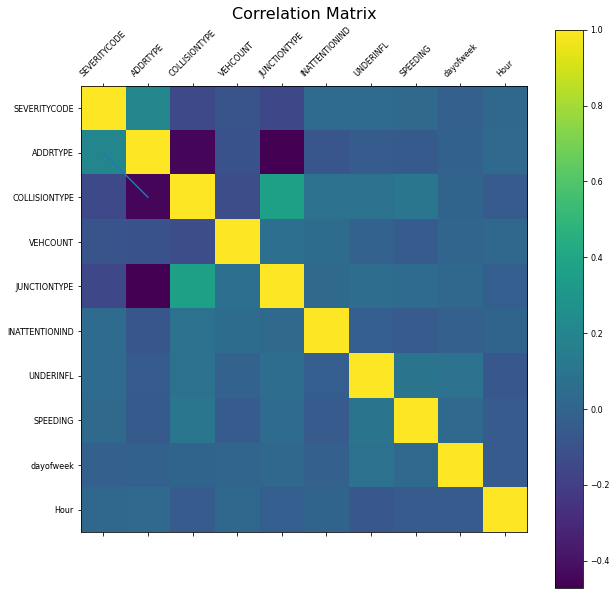

In [52]:

# let's visualize the correlations
f = plt.figure(figsize=(10, 10))
plt.matshow(Feature.corr(), fignum=f.number)
plt.xticks(range(Feature.shape[1]), Feature.columns, fontsize=8, rotation=45)
plt.yticks(range(Feature.shape[1]), Feature.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title("Correlation Matrix", fontsize=16)
plt.plot([1, 2])
f.savefig("test.png", bbox_inches="tight")


In [53]:

Feature.drop(columns=["SEVERITYCODE"], axis=1, inplace=True)
X = Feature.values
Y = df["SEVERITYCODE"].values
print(f"X:\n{X[0:5]}")
print(f"Y:\n{Y[0:5]}")


X:
[[ 1  0  2  1  0  0  0  2 14]
 [ 0 11  2  2  0  0  0  2 18]
 [ 0  6  3  2  0  0  0  3 10]
 [ 0 10  3  2  0  0  0  4  9]
 [ 1  0  2  1  0  0  0  2  8]]
Y:
[2 1 1 1 2]


In [54]:

X = preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])


[[ 1.37609549 -1.61543555  0.05066432 -0.70835155 -0.44305634 -0.23442322
  -0.22508012 -0.49508378  0.20461975]
 [-0.72669375  1.32653435  0.05066432  0.94795427 -0.44305634 -0.23442322
  -0.22508012 -0.49508378  0.86249285]
 [-0.72669375 -0.0107247   1.82925322  0.94795427 -0.44305634 -0.23442322
  -0.22508012  0.02378129 -0.45325334]
 [-0.72669375  1.05908254  1.82925322  0.94795427 -0.44305634 -0.23442322
  -0.22508012  0.54264636 -0.61772162]
 [ 1.37609549 -1.61543555  0.05066432 -0.70835155 -0.44305634 -0.23442322
  -0.22508012 -0.49508378 -0.78218989]]



## for KNN cluster


In [55]:

# split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=4
)
print(f"Train set: {X_train.shape, Y_train.shape}")
print(f"Test set: {X_test.shape, Y_test.shape}")


Train set: ((122956, 9), (122956,))
Test set: ((40986, 9), (40986,))


In [56]:

# find the best K
Ks = 15
mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))
for n in range(1, Ks):
    # Train Model and Predict
    KSEVERITY = KNeighborsClassifier(n_neighbors=n).fit(X_train, Y_train)
    yhat = KSEVERITY.predict(X_test)
    mean_acc[n - 1] = metrics.accuracy_score(Y_test, yhat)
    numerator = np.std(yhat == Y_test)
    denominator = np.sqrt(yhat.shape[0])
    std_acc[n - 1] = numerator / denominator
    # yes i know i suck at variable names
print(f"mean accuracies for different ks are {mean_acc}")


mean accuracies for different ks are [0.67344947 0.72017274 0.70814424 0.72922461 0.72127068 0.73366515
 0.72697994 0.73708095 0.72883424 0.73727614 0.73142049 0.73905724
 0.73305519 0.73878885]


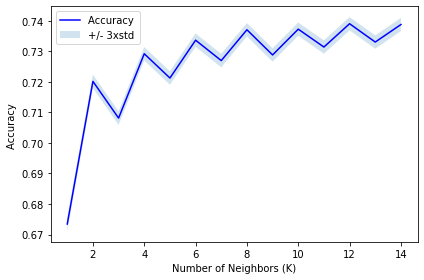

In [57]:

# plot accuracy to find the best K
plt.plot(range(1, Ks), mean_acc, "b")
plt.fill_between(
    range(1, Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.20
)
plt.legend(("Accuracy ", "+/- 3xstd"))
plt.ylabel("Accuracy ")
plt.xlabel("Number of Neighbors (K)")
plt.tight_layout()
plt.show()


In [58]:

print(f"The best accuracy was with {mean_acc.max()} with k= {mean_acc.argmax()+1}")


The best accuracy was with 0.7390572390572391 with k= 12


In [59]:

# implement the model with best value of K
k = mean_acc.argmax() + 1
# Train Model and Predict
KSEVERITY = KNeighborsClassifier(n_neighbors=k).fit(X_train, Y_train)
print(KSEVERITY)


KNeighborsClassifier(n_neighbors=12)



## Logistic Regression


In [60]:

SEVERITYLR = LogisticRegression(C=0.01, solver="newton-cg").fit(X_train, Y_train)
yhat = SEVERITYLR.predict(X_test)
print(yhat[0:5])
yhat_prob = SEVERITYLR.predict_proba(X_test)
print(yhat_prob[0:5])


[1 1 1 1 1]
[[0.77740932 0.22259068]
 [0.66488274 0.33511726]
 [0.69491518 0.30508482]
 [0.80103424 0.19896576]
 [0.62845545 0.37154455]]



## Decision Tree


In [61]:

SEVERITYTree = DecisionTreeClassifier(criterion="entropy", max_depth=6)
SEVERITYTree.fit(X_train, Y_train)
predTree = SEVERITYTree.predict(X_test)
print(predTree)


[1 1 2 ... 2 1 1]


In [62]:

print(f"DecisionTrees's Accuracy: {metrics.accuracy_score(Y_test, predTree)}")


DecisionTrees's Accuracy: 0.7546479285609721


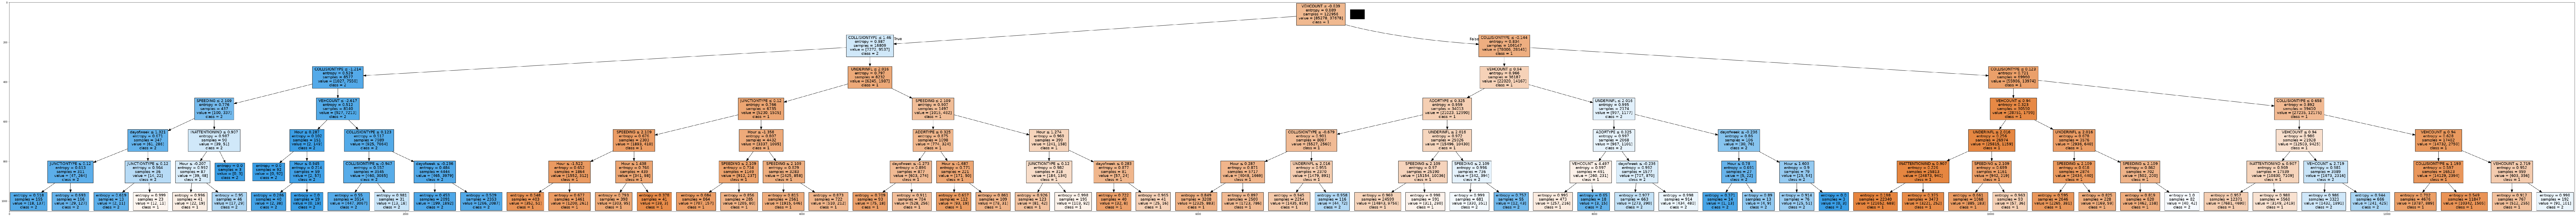

In [63]:

dot_data = StringIO()
FILE_NAME = "Sevrtree.png"
featureNames = Feature.columns
targetNames = Y
out = tree.export_graphviz(
    SEVERITYTree,
    feature_names=featureNames,
    out_file=dot_data,
    class_names=np.unique(Y_train).astype(str),
    filled=True,
    special_characters=True,
    rotate=False,
)
dot_data_val = dot_data.getvalue()
graph = pydotplus.graph_from_dot_data(dot_data_val)
graph.write_png(FILE_NAME)
img = mpimg.imread(FILE_NAME)
plt.figure(figsize=(200, 200))
plt.imshow(img, interpolation="nearest")



## SVM


In [64]:

SEVERITYSVM = svm.SVC(kernel="sigmoid")
SEVERITYSVM.fit(X_train, Y_train)
yhat = SEVERITYSVM.predict(X_test)
print(yhat[0:5])


[1 1 2 1 1]



## Model Evaluation


In [65]:

# fetch random records from cleaned dataset.
df_Test = df.sample(frac=0.25)
# apply encoding
le_lc = preprocessing.LabelEncoder()
le_lc.fit(
    ["Non Intersection", "Intersection Related", "Driveway Junction", "Ramp Junction"]
)
df_Test["JUNCTIONTYPE"] = le_lc.transform(df_Test["JUNCTIONTYPE"])
le_lc = preprocessing.LabelEncoder()
le_lc.fit(["Block", "Intersection"])
df_Test["ADDRTYPE"] = le_lc.transform(df_Test["ADDRTYPE"])
le_lc = preprocessing.LabelEncoder()
le_lc.fit(
    [
        "Angles",
        "Sideswipe",
        "Parked Car",
        "Same Direction",
        "Rear Ended",
        "Head On",
        "Struck Object",
        "Cycles",
        "Left Turn",
        "Driveway",
        "Pedestrian",
        "Breakdown",
        "Right Turn",
    ]
)
df_Test["COLLISIONTYPE"] = le_lc.transform(df_Test["COLLISIONTYPE"])
X_Eval = df_Test[
    [
        "ADDRTYPE",
        "COLLISIONTYPE",
        "VEHCOUNT",
        "JUNCTIONTYPE",
        "INATTENTIONIND",
        "UNDERINFL",
        "SPEEDING",
        "dayofweek",
        "Hour",
    ]
].values
X_Eval = preprocessing.StandardScaler().fit(X_Eval).transform(X_Eval)
print(X_Eval[0:5])


[[-0.72672618 -0.01817129  0.05892749  0.95079092 -0.44300385 -0.23331924
  -0.22673408 -0.49264904  1.53138391]
 [-0.72672618  0.51724812  0.05892749 -0.70444064 -0.44300385 -0.23331924
  -0.22673408  0.54634003 -0.12043017]
 [-0.72672618 -0.01817129  0.05892749  0.95079092 -0.44300385 -0.23331924
  -0.22673408 -1.01214358 -1.11151861]
 [ 1.37603409  0.24953841 -1.72878673 -0.70444064 -0.44300385 -0.23331924
  -0.22673408 -0.49264904  0.37511406]
 [ 1.37603409 -1.6244295   0.05892749 -0.70444064 -0.44300385 -0.23331924
  -0.22673408  0.54634003  1.53138391]]


In [66]:

Y_Eval = df_Test["SEVERITYCODE"].values
print(Y_Eval[0:5])


[1 2 1 2 1]


In [67]:

KSEVERITY_yhat = KSEVERITY.predict(X_Eval)
KSEVERITY_yhat_prob = KSEVERITY.predict_proba(X_Eval)


In [68]:

print(f"KNN Jaccard index: {jaccard_score(Y_Eval, KSEVERITY_yhat)}")
print(f"KNN F1-score: {f1_score(Y_Eval, KSEVERITY_yhat, average='weighted')}")
print(f"KNN LogLoss: {log_loss(Y_Eval, KSEVERITY_yhat_prob)}")


KNN Jaccard index: 0.7194826637314254
KNN F1-score: 0.7267132199580001
KNN LogLoss: 0.6844203549938522


In [69]:

SEVERITYTree_yhat = SEVERITYTree.predict(X_Eval)
SEVERITYTree_yhat_prob = SEVERITYTree.predict_proba(X_Eval)
print(f"DT Jaccard index: {jaccard_score(Y_Eval, SEVERITYTree_yhat)}")
print(f"DT F1-score: {f1_score(Y_Eval, SEVERITYTree_yhat, average='weighted')}")
print(f"DT LogLoss: {log_loss(Y_Eval, SEVERITYTree_yhat_prob)}")


DT Jaccard index: 0.7284246206822339
DT F1-score: 0.7166766194070686
DT LogLoss: 0.48574709581650005


In [70]:

SEVERITYLR_yhat = SEVERITYLR.predict(X_Eval)
SEVERITYLR_yhat_prob = SEVERITYLR.predict_proba(X_Eval)
print(f"LR Jaccard index: {jaccard_score(Y_Eval, SEVERITYLR_yhat)}")
print(f"LR F1-score: {f1_score(Y_Eval, SEVERITYLR_yhat, average='weighted')}")
print(f"LR LogLoss: {log_loss(Y_Eval, SEVERITYLR_yhat_prob)}")


LR Jaccard index: 0.6951659724851698
LR F1-score: 0.6258515472547153
LR LogLoss: 0.5818070707534237


In [71]:

SEVERITYSVM_yhat = SEVERITYSVM.predict(X_Eval)
print(f"SVM Jaccard index: {jaccard_score(Y_Eval, SEVERITYSVM_yhat)}")
print(f"SVM F1-score: {f1_score(Y_Eval, SEVERITYSVM_yhat, average='weighted')}")


SVM Jaccard index: 0.5540500013631778
SVM F1-score: 0.6004230625512689


In [72]:

# Let's visualize the models using confusion matrix and classification report
def plot_confusion_matrix(
    confu_matrix, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """plot confusion matrix"""
    if normalize:
        confu_matrix = confu_matrix.astype("float") / confu_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(confu_matrix)
    plt.imshow(confu_matrix, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = confu_matrix.max() / 2.0
    for xi, xj in itertools.product(range(confu_matrix.shape[0]), range(confu_matrix.shape[1])):
        plt.text(
            xj,
            xi,
            format(confu_matrix[xi, xj], fmt),
            horizontalalignment="center",
            color="white" if confu_matrix[xi, xj] > thresh else "black",
        )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


In [73]:

print(classification_report(Y_Eval, KSEVERITY_yhat))


              precision    recall  f1-score   support

           1       0.77      0.92      0.84     28446
           2       0.67      0.37      0.48     12540

    accuracy                           0.75     40986
   macro avg       0.72      0.64      0.66     40986
weighted avg       0.74      0.75      0.73     40986



Normalized confusion matrix
[[0.92 0.08]
 [0.63 0.37]]


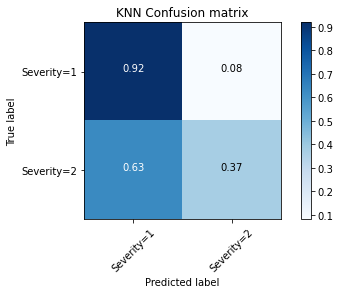

In [74]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_Eval, KSEVERITY_yhat, labels=[1, 2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["Severity=1", "Severity=2"],
    normalize=True,
    title="KNN Confusion matrix",
)


In [75]:

print(classification_report(Y_Eval, SEVERITYTree_yhat))


              precision    recall  f1-score   support

           1       0.76      0.95      0.84     28446
           2       0.74      0.30      0.43     12540

    accuracy                           0.75     40986
   macro avg       0.75      0.63      0.64     40986
weighted avg       0.75      0.75      0.72     40986



Normalized confusion matrix
[[0.95 0.05]
 [0.7  0.3 ]]


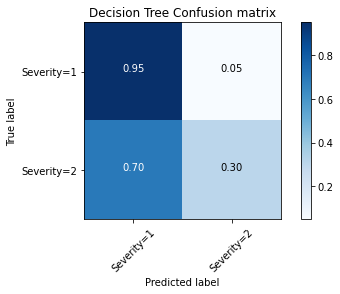

In [76]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_Eval, SEVERITYTree_yhat, labels=[1, 2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["Severity=1", "Severity=2"],
    normalize=True,
    title="Decision Tree Confusion matrix",
)


In [77]:

print(classification_report(Y_Eval, SEVERITYLR_yhat))


              precision    recall  f1-score   support

           1       0.71      0.97      0.82     28446
           2       0.60      0.11      0.19     12540

    accuracy                           0.71     40986
   macro avg       0.66      0.54      0.50     40986
weighted avg       0.68      0.71      0.63     40986



Normalized confusion matrix
[[0.97 0.03]
 [0.89 0.11]]


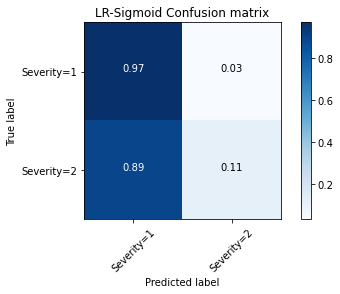

In [78]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_Eval, SEVERITYLR_yhat, labels=[1, 2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["Severity=1", "Severity=2"],
    normalize=True,
    title="LR-Sigmoid Confusion matrix",
)


In [79]:

print(classification_report(Y_Eval, SEVERITYSVM_yhat))


              precision    recall  f1-score   support

           1       0.71      0.71      0.71     28446
           2       0.35      0.34      0.34     12540

    accuracy                           0.60     40986
   macro avg       0.53      0.53      0.53     40986
weighted avg       0.60      0.60      0.60     40986



Normalized confusion matrix
[[0.71 0.29]
 [0.66 0.34]]


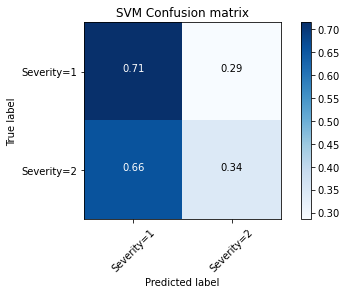

In [80]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_Eval, SEVERITYSVM_yhat, labels=[1, 2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(
    cnf_matrix,
    classes=["Severity=1", "Severity=2"],
    normalize=True,
    title="SVM Confusion matrix",
)


In [81]:

print("from the performance and confusion matrix seems KNN is best fit here")


from the performance and confusion matrix seems KNN is best fit here
